# 一、数据概况

In [1]:
import pandas as pd

filename = "records-for-2011.csv"
data = pd.read_csv(filename)

# 显示前5行数据
data.head()

,Agency,Create Time,Location,Area Id,Beat,Priority,Incident Type Id,Incident Type Description,Event Number,Closed Time
0,OP,2011-01-01T00:00:00.000,ST&SAN PABLO AV,1.0,06X,1.0,PDOA,POSSIBLE DEAD PERSON,LOP110101000001,2011-01-01T00:28:17.000
1,OP,2011-01-01T00:01:11.000,ST&HANNAH ST,1.0,07X,1.0,415GS,415 GUNSHOTS,LOP110101000002,2011-01-01T01:12:56.000
2,OP,2011-01-01T00:01:25.000,ST&MARKET ST,1.0,10Y,2.0,415GS,415 GUNSHOTS,LOP110101000003,2011-01-01T00:07:20.000
3,OP,2011-01-01T00:01:35.000,PRENTISS ST,2.0,21Y,2.0,415GS,415 GUNSHOTS,LOP110101000005,2011-01-01T00:02:28.000
4,OP,2011-01-01T00:02:10.000,AV&FOOTHILL BLVD,2.0,20X,1.0,415GS,415 GUNSHOTS,LOP110101000004,2011-01-01T00:50:04.000


In [2]:
# 显示数据概况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180016 entries, 0 to 180015
Data columns (total 10 columns):
Agency                       180015 non-null object
Create Time                  180015 non-null object
Location                     180016 non-null object
Area Id                      179112 non-null float64
Beat                         179496 non-null object
Priority                     180015 non-null float64
Incident Type Id             180015 non-null object
Incident Type Description    180015 non-null object
Event Number                 180015 non-null object
Closed Time                  180009 non-null object
dtypes: float64(2), object(8)
memory usage: 13.7+ MB


# 二、关联规则挖掘
## 2.1 数据集处理

In [3]:
data = data[["Agency", "Location", "Area Id", "Beat", "Priority", "Incident Type Id", "Incident Type Description", "Event Number"]]
data = data[:5000]
print(data.columns)

Index(['Agency', 'Location', 'Area Id', 'Beat', 'Priority', 'Incident Type Id',
       'Incident Type Description', 'Event Number'],
      dtype='object')


In [4]:
# 转化为数据字典
rows = data.values.tolist()
dataset = []
feature_names = ["Agency", "Location", "Area Id", "Beat", "Priority", "Incident Type Id", "Incident Type Description", "Event Number"]
for data_line in rows:
    data_set = []
    for i, value in enumerate(data_line):
        if not value:
            data_set.append((feature_names[i], 'NA'))
        else:
            data_set.append((feature_names[i], value))
    dataset.append(data_set)

## 2.2 获取频繁项集

In [5]:
from progressbar import *
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

min_sup = 0.1
min_conf = 0.5

class Association_rules():
    def __init__(self):
        self.min_sup = min_sup
        self.min_conf = min_conf

    def apriori(self, dataset):             #算法主体
        C1 = self.C1_generation(dataset)        #生成单元数候选项集
        dataset = [set(data) for data in dataset]
        F1, sup_rata = self.Ck_low_support_filtering(dataset, C1)
        F = [F1]
        k = 2
        while len(F[k-2]) > 0:
            Ck = self.apriori_gen(F[k-2], k)        #当候选项元素大于2时，合并时检测是否子项集满足频繁
            Fk, support_k = self.Ck_low_support_filtering(dataset, Ck)      #过滤支持度低于阈值的项集
            sup_rata.update(support_k)
            F.append(Fk)
            k += 1
        return F, sup_rata

    def C1_generation(self, dataset):       #生成单元数候选项集
        C1 = []
        progress = ProgressBar()
        for data in progress(dataset):
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        return [frozenset(item) for item in C1]

    def Ck_low_support_filtering(self, dataset, Ck):        #过滤支持度低于阈值的项集
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        sup_rata = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_sup:
                return_list.insert(0, key)
            sup_rata[key] = support
        return return_list, sup_rata

    def apriori_gen(self, Fk, k):       #当候选项元素大于2时，合并时检测是否子项集满足频繁
        return_list = []
        len_Fk = len(Fk)

        for i in range(len_Fk):
            for j in range(i+1, len_Fk):
                # 第k-2个项相同时，将两个集合合并
                F1 = list(Fk[i])[:k-2]
                F2 = list(Fk[j])[:k-2]
                F1.sort()
                F2.sort()
                if F1 == F2:
                    return_list.append(Fk[i] | Fk[j])
        return return_list

    def generate_rules(self, F, sup_rata):
        """
        产生强关联规则算法实现
        基于Apriori算法，首先从一个频繁项集开始，接着创建一个规则列表，
        其中规则右部只包含一个元素，然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表，
        其中规则右部包含两个元素。这种方法称作分级法。
        :param F: 频繁项集
        :param sup_rata: 频繁项集对应的支持度
        :return: 强关联规则列表
        """
        strong_rules_list = []
        for i in range(1, len(F)):
            for freq_set in F[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_reasoned_item(freq_set, H1, sup_rata, strong_rules_list)
                else:
                    self.cal_conf(freq_set, H1, sup_rata, strong_rules_list)
        return strong_rules_list

    def rules_from_reasoned_item(self, freq_set, H, sup_rata, strong_rules_list):
        """
        H->出现在规则右部的元素列表
        """
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, sup_rata, strong_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_reasoned_item(freq_set, Hmp1, sup_rata, strong_rules_list)

    def cal_conf(self, freq_set, H, sup_rata, strong_rules_list):          #评估规则
        prunedH = []
        for reasoned_item in H:
            sup = sup_rata[freq_set]
            conf = sup / sup_rata[freq_set - reasoned_item]
            lift = conf / sup_rata[reasoned_item]
            jaccard = sup / (sup_rata[freq_set - reasoned_item] + sup_rata[reasoned_item] - sup)
            if conf >= self.min_conf:
                strong_rules_list.append((freq_set-reasoned_item, reasoned_item, sup, conf, lift, jaccard))
                prunedH.append(reasoned_item)
        return prunedH

association = Association_rules()
freq_set, sup_rata = association.apriori(dataset)
sup_rata_out = sorted(sup_rata.items(), key=lambda d: d[1], reverse=True)
print("sup_rata ", sup_rata)

100% |########################################################################|


sup_rata  {frozenset({('Agency', 'OP')}): 1.0, frozenset({('Location', ' ST&SAN PABLO AV')}): 0.0054, frozenset({('Area Id', 1.0)}): 0.3574, frozenset({('Beat', '06X')}): 0.0264, frozenset({('Priority', 1.0)}): 0.1956, frozenset({('Incident Type Id', 'PDOA')}): 0.005, frozenset({('Incident Type Description', 'POSSIBLE DEAD PERSON')}): 0.005, frozenset({('Event Number', 'LOP110101000001')}): 0.0002, frozenset({('Location', ' ST&HANNAH ST ')}): 0.0004, frozenset({('Beat', '07X')}): 0.0232, frozenset({('Incident Type Id', '415GS')}): 0.0218, frozenset({('Incident Type Description', '415 GUNSHOTS')}): 0.0218, frozenset({('Event Number', 'LOP110101000002')}): 0.0002, frozenset({('Location', ' ST&MARKET ST ')}): 0.0048, frozenset({('Beat', '10Y')}): 0.0134, frozenset({('Priority', 2.0)}): 0.8044, frozenset({('Event Number', 'LOP110101000003')}): 0.0002, frozenset({('Location', ' PRENTISS ST ')}): 0.0002, frozenset({('Area Id', 2.0)}): 0.2956, frozenset({('Beat', '21Y')}): 0.0198, frozenset({

## 2.3 获取强关联规则列表

In [6]:
strong_rules_list = association.generate_rules(freq_set, sup_rata)
strong_rules_list = sorted(strong_rules_list, key=lambda x: x[3], reverse=True)
print("strong_rules_list ", strong_rules_list)

strong_rules_list  [(frozenset({('Area Id', 3.0)}), frozenset({('Agency', 'OP')}), 0.3456, 1.0, 1.0, 0.3456), (frozenset({('Area Id', 2.0)}), frozenset({('Agency', 'OP')}), 0.2956, 1.0, 1.0, 0.29560000000000003), (frozenset({('Priority', 2.0)}), frozenset({('Agency', 'OP')}), 0.8044, 1.0, 1.0, 0.8044), (frozenset({('Area Id', 1.0)}), frozenset({('Agency', 'OP')}), 0.3574, 1.0, 1.0, 0.3574), (frozenset({('Priority', 1.0)}), frozenset({('Agency', 'OP')}), 0.1956, 1.0, 1.0, 0.1956), (frozenset({('Area Id', 1.0)}), frozenset({('Priority', 2.0)}), 0.296, 0.8282036933407946, 1.0295918614380837, 0.3418803418803419), (frozenset({('Area Id', 1.0)}), frozenset({('Priority', 2.0), ('Agency', 'OP')}), 0.296, 0.8282036933407946, 1.0295918614380837, 0.3418803418803419), (frozenset({('Agency', 'OP')}), frozenset({('Priority', 2.0)}), 0.8044, 0.8044, 1.0, 0.8044), (frozenset({('Area Id', 2.0)}), frozenset({('Priority', 2.0)}), 0.2364, 0.7997293640054128, 0.9941936399868384, 0.2737378415933302), (froze

In [8]:
# 将频繁项集输出到结果文件
freq_set_file = open(os.path.join('./results', '频繁项集.json'), 'w')
for (key, value) in sup_rata_out:
    result_dict = {'set': None, 'sup': None}
    set_result = list(key)
    sup_result = value
    if sup_result < min_sup:
        continue
    result_dict['set'] = set_result
    result_dict['sup'] = sup_result
    json_str = json.dumps(result_dict, ensure_ascii=False)
    freq_set_file.write(json_str + '\n')
freq_set_file.close()

In [9]:
# 将关联规则输出到结果文件
rules_file = open(os.path.join('./results', '规则.json'), 'w')
for result in strong_rules_list:
    result_dict = {'X_set': None, 'Y_set': None, 'sup': None, 'conf': None, 'lift': None, 'jaccard': None}
    X_set, Y_set, sup, conf, lift, jaccard = result
    result_dict['X_set'] = list(X_set)
    result_dict['Y_set'] = list(Y_set)
    result_dict['sup'] = sup
    result_dict['conf'] = conf
    result_dict['lift'] = lift
    result_dict['jaccard'] = jaccard

    json_str = json.dumps(result_dict, ensure_ascii=False)
    rules_file.write(json_str + '\n')
rules_file.close()

## 2.4 可视化

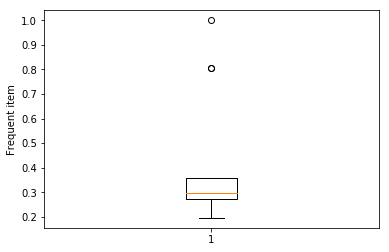

No handles with labels found to put in legend.


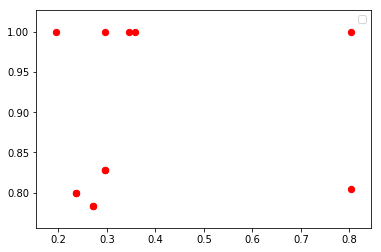

In [10]:
with open("./results/频繁项集.json") as f1:
    freq = [json.loads(each) for each in f1.readlines()]

with open("./results/规则.json") as f2:
    rules = [json.loads(each) for each in f2.readlines()]

freq_sup = [each["sup"] for each in freq]
plt.boxplot(freq_sup)
plt.ylabel("Frequent item")
plt.show()

rules_sup = [each["sup"] for each in rules]
rules_conf = [each["conf"] for each in rules]


plt.scatter(rules_sup, rules_conf, marker='o', color='red', s=40)
plt.xlabel = 'Sup'
plt.ylabel = 'Conf'
plt.legend(loc='best')
plt.show()